# E2E Machine Learning Using Snowflake

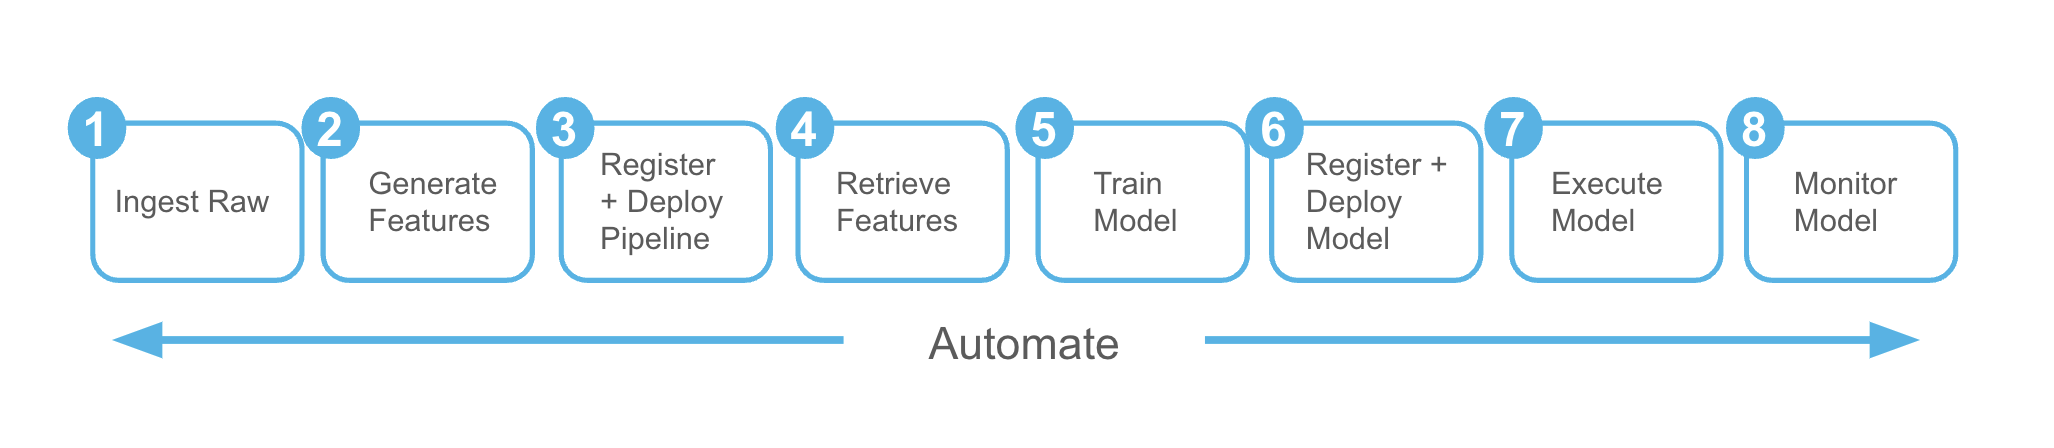

In [35]:
from IPython.display import Image
Image("Process.png")

# 0. Set Up Environment

In [1]:
import json
import numpy as np
import pandas as pd
import os
import sys

from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import sproc, col
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

from snowflake.snowpark.types import PandasDataFrameType, IntegerType, StringType, FloatType, Variant
from snowflake.snowpark.exceptions import SnowparkSQLException
from snowflake.ml.modeling.linear_model import LinearRegression
from snowflake.ml.registry import registry
from snowflake.ml._internal.utils import identifier

from snowflake.ml.feature_store import (
    FeatureStore,
    FeatureView,
    Entity,
    CreationMode
)

from snowflake.ml.modeling.ensemble import RandomForestClassifier
from snowflake.ml.modeling import metrics as snowml_metrics
from snowflake.snowpark.functions import abs as sp_abs, mean, col

In [2]:
# Reading Snowflake Connection Details
snowflake_connection_cfg = json.loads(open("/Users/mitaylor/Documents/creds/creds.json").read())

# Creating Snowpark Session
session = Session.builder.configs(snowflake_connection_cfg).create()

# Create a fresh & new schema
session.sql("CREATE OR REPLACE DATABASE MODEL_REGISTRY").collect()
session.sql("CREATE OR REPLACE SCHEMA PUBLIC").collect()
REGISTRY_DATABASE_NAME = "MODEL_REGISTRY"
REGISTRY_SCHEMA_NAME = "PUBLIC"
native_registry = registry.Registry(session=session, database_name=REGISTRY_DATABASE_NAME, schema_name=REGISTRY_SCHEMA_NAME)
session.sql("CREATE OR REPLACE DATABASE MBDA_TEST").collect()
session.sql("CREATE OR REPLACE STAGE MONITORING").collect()
session.sql("CREATE OR REPLACE WAREHOUSE MBDA_WH WITH WAREHOUSE_SIZE='X-SMALL'").collect()

[Row(status='Warehouse MBDA_WH successfully created.')]

In [3]:
# Create our external stages (in S3)
aws_connection_cfg = json.loads(open("/Users/mitaylor/Documents/creds/aws_creds.json").read())
AWS_SECRET_KEY = aws_connection_cfg['password']
AWS_KEY_ID = aws_connection_cfg['account']
session.use_schema('PUBLIC')
session.sql(f"""
CREATE OR REPLACE STAGE IRIS_DATA 
URL = 's3://mtaylor-raw-data-store/iris_data'
CREDENTIALS = (AWS_KEY_ID = '{AWS_KEY_ID}'  AWS_SECRET_KEY = '{AWS_SECRET_KEY}')
file_format = (type = 'CSV' field_delimiter = ',')
DIRECTORY=(ENABLE=TRUE AUTO_REFRESH=FALSE);
""").collect()


[Row(status='Stage area IRIS_DATA successfully created.')]

In [4]:
fs = FeatureStore(
    session=session, 
    database="MBDA_TEST", 
    name="PUBLIC", 
    default_warehouse="MBDA_WH",
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)


FeatureStore.__init__() is in private preview since 1.0.8. Do not use it in production. 
FeatureStore.update_default_warehouse() is in private preview since 1.0.12. Do not use it in production. 


# 1. Ingest Raw: Manual for brevity, can be automated via Snowpipe

In [5]:
session.sql('''create or replace table IRIS_TABLE(IRIS_ID int, SEP_LEN float, SEP_WIDTH float, PET_LEN float, PET_WIDTH float, IRIS_TYPE int);''').collect()
session.sql('''copy into MBDA_TEST.public.IRIS_TABLE from @MBDA_TEST.public.IRIS_DATA;''').collect()
sdf = session.table('IRIS_TABLE')
sdf.limit(3).show()

-------------------------------------------------------------------------------
|"IRIS_ID"  |"SEP_LEN"  |"SEP_WIDTH"  |"PET_LEN"  |"PET_WIDTH"  |"IRIS_TYPE"  |
-------------------------------------------------------------------------------
|0          |5.1        |3.5          |1.4        |0.2          |0            |
|1          |4.9        |3.0          |1.4        |0.2          |0            |
|2          |4.7        |3.2          |1.3        |0.2          |0            |
-------------------------------------------------------------------------------



# 2. Generate Features: Using Snowpark (or pandas via a UD(T)F)

In [6]:
entity = Entity(name="IRIS", join_keys=["IRIS_ID"])
fs.register_entity(entity)
fs.list_entities().show()
sdf = sdf.withColumn("MY_NEW_FEATURE", sdf["SEP_LEN"] * sdf["SEP_WIDTH"])
sdf.limit(3).show()

FeatureStore.register_entity() is in private preview since 1.0.8. Do not use it in production. 
FeatureStore.list_entities() is in private preview since 1.0.8. Do not use it in production. 


---------------------------------
|"NAME"  |"JOIN_KEYS"  |"DESC"  |
---------------------------------
|IRIS    |["IRIS_ID"]  |        |
---------------------------------

----------------------------------------------------------------------------------------------------
|"IRIS_ID"  |"SEP_LEN"  |"SEP_WIDTH"  |"PET_LEN"  |"PET_WIDTH"  |"IRIS_TYPE"  |"MY_NEW_FEATURE"    |
----------------------------------------------------------------------------------------------------
|0          |5.1        |3.5          |1.4        |0.2          |0            |17.849999999999998  |
|1          |4.9        |3.0          |1.4        |0.2          |0            |14.700000000000001  |
|2          |4.7        |3.2          |1.3        |0.2          |0            |15.040000000000001  |
----------------------------------------------------------------------------------------------------



# 3. Register + Deploy Pipeline

In [7]:
fv = FeatureView(
    name="IRIS_FEATURES", 
    entities=[entity], #ie wine
    feature_df=sdf['IRIS_ID', 'SEP_LEN', 'SEP_WIDTH', 'PET_LEN', 'PET_WIDTH', 'MY_NEW_FEATURE'], 
    refresh_freq="1 minute", 
    desc="iris features")

fv = fs.register_feature_view(
    feature_view=fv, 
    version="V1", 
    block=True)

fs.read_feature_view(fv).limit(3).show()

FeatureStore.register_feature_view() is in private preview since 1.0.8. Do not use it in production. 
FeatureStore.get_feature_view() is in private preview since 1.0.8. Do not use it in production. 
FeatureStore.read_feature_view() is in private preview since 1.0.8. Do not use it in production. 


--------------------------------------------------------------------------------------
|"IRIS_ID"  |"SEP_LEN"  |"SEP_WIDTH"  |"PET_LEN"  |"PET_WIDTH"  |"MY_NEW_FEATURE"    |
--------------------------------------------------------------------------------------
|0          |5.1        |3.5          |1.4        |0.2          |17.849999999999998  |
|1          |4.9        |3.0          |1.4        |0.2          |14.700000000000001  |
|2          |4.7        |3.2          |1.3        |0.2          |15.040000000000001  |
--------------------------------------------------------------------------------------



# 4. Retrieve Features: Using the Feature Store to Hydrate A Spine DataFrame (that only includes ID and Iris Type)

In [8]:
spine_df = session.table("IRIS_TABLE")
spine_df = spine_df.select("IRIS_ID", "IRIS_TYPE")

In [9]:
session.sql(f"DROP TABLE IF EXISTS IRIS_TRAINING_DATA_TABLE").collect()
training_data = fs.generate_dataset( 
    spine_df=spine_df, 
    features=[fv.slice(["SEP_LEN", 
                        "SEP_WIDTH", 
                        "MY_NEW_FEATURE"])], 
    materialized_table="IRIS_TRAINING_DATA_TABLE", 
    spine_timestamp_col=None, 
    spine_label_cols=["IRIS_TYPE"], 
    save_mode="merge",
    exclude_columns=['IRIS_ID'] 
)

training_data.df.limit(3).show()

FeatureStore.generate_dataset() is in private preview since 1.0.8. Do not use it in production. 


--------------------------------------------------------------
|"IRIS_TYPE"  |"SEP_LEN"  |"SEP_WIDTH"  |"MY_NEW_FEATURE"    |
--------------------------------------------------------------
|0            |5.1        |3.5          |17.849999999999998  |
|0            |4.9        |3.0          |14.700000000000001  |
|0            |4.7        |3.2          |15.040000000000001  |
--------------------------------------------------------------



# 5. Train Model: Using Snowpark ML

In [10]:
def snowpark_train_model(training_data):
    train, test = training_data.df.random_split([0.8, 0.2], seed=42)
    feature_columns = [col for col in training_data.df.columns if col != "IRIS_TYPE"]
    label_column = "IRIS_TYPE"

    rf = RandomForestClassifier(input_cols=feature_columns,
                               label_cols=[label_column],
                               max_depth=3,
                               n_estimators=20,
                               random_state=42)

    rf.fit(train)
    predictions = rf.predict(test)

    accuracy = 100 - snowml_metrics.mean_absolute_percentage_error(df=predictions,
                                                                   y_true_col_names=label_column,
                                                                   y_pred_col_names="OUTPUT_" + label_column)

    print(f"Accuracy: {accuracy}")
    return rf

rf = snowpark_train_model(training_data)

The version of package 'snowflake-snowpark-python' in the local environment is 1.13.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


Accuracy: 99.728571428571


# 6. Register and Deploy Model

In [11]:
MODEL_NAME = "MBDA_MODEL"
MODEL_VERSION = "v1"

model = native_registry.log_model(model_name=MODEL_NAME,
                                  version_name=MODEL_VERSION,
                                  model=rf)

# 7. Execute Model

In [12]:
df = pd.read_csv("iris2.csv")
df.columns = columns=['IRIS_ID', 'SEP_LEN', 'SEP_WIDTH', 'PET_LEN', 'PET_WIDTH', 'IRIS_TYPE']
session.write_pandas(df, table_name='IRIS_TABLE')
spine_df = session.sql("select IRIS_ID, IRIS_TYPE from IRIS_TABLE WHERE IRIS_ID > 149")
enriched_df = fs.retrieve_feature_values(spine_df, training_data.load_features())
enriched_df = enriched_df.drop('IRIS_ID')

In [15]:
model.run(enriched_df, function_name="predict").limit(3).to_pandas()

,IRIS_TYPE,SEP_LEN,SEP_WIDTH,MY_NEW_FEATURE,OUTPUT_IRIS_TYPE
0,2,6.5,3.0,19.50,2
1,2,6.9,3.1,21.39,2
2,2,5.8,2.7,15.66,1


In [16]:
session.table('IRIS_FEATURES$V1').to_pandas()

,IRIS_ID,SEP_LEN,SEP_WIDTH,PET_LEN,PET_WIDTH,MY_NEW_FEATURE
0,153,6.8,3.2,5.9,2.3,21.76
1,154,6.7,3.3,5.7,2.5,22.11
2,159,5.9,3.0,5.1,1.8,17.70
3,152,5.8,2.7,5.1,1.9,15.66
4,155,6.7,3.0,5.2,2.3,20.10
...,...,...,...,...,...,...
154,145,6.7,3.0,5.2,2.3,20.10
155,146,6.3,2.5,5.0,1.9,15.75
156,147,6.5,3.0,5.2,2.0,19.50
157,148,6.2,3.4,5.4,2.3,21.08


# 8. Monitor the Data Drift Using Evidently

In [19]:
@sproc(session=session, name='evidently_monitor', stage_location='@MONITORING',  
       packages=['snowflake-snowpark-python', 'pandas', 'evidently', 'snowflake-ml-python'], 
       is_permanent=True, 
       replace=True)
def monitor_model(session: Session) -> str:   
    from evidently.report import Report
    from evidently.metrics import ColumnSummaryMetric, ColumnQuantileMetric, ColumnDriftMetric
    from joblib import dump

    report = Report(metrics=[ColumnSummaryMetric(column_name='SEP_LEN'),
                             ColumnQuantileMetric(column_name='SEP_LEN', quantile=0.25),
                             ColumnDriftMetric(column_name='SEP_LEN'),
                             ColumnSummaryMetric(column_name='SEP_WIDTH'),
                             ColumnQuantileMetric(column_name='SEP_WIDTH', quantile=0.25),
                             ColumnDriftMetric(column_name='SEP_WIDTH')])
    
    reference = session.sql('select SEP_LEN, SEP_WIDTH, MY_NEW_FEATURE from IRIS_FEATURES$V1 WHERE IRIS_ID < 100').to_pandas()
    current = session.sql('select SEP_LEN, SEP_WIDTH, MY_NEW_FEATURE from IRIS_FEATURES$V1 WHERE IRIS_ID > 100').to_pandas()
    report.run(reference_data=reference, current_data=current)
    
    report.save_html("/tmp/report.html")
    session.file.put("/tmp/report.html", '@MONITORING', auto_compress=False, overwrite=True)

    return('Report Executed')

monitor_model()

'Report Executed'

# Bonus. Schedule Monitoring With Tasks

In [27]:
session.sql("CREATE OR REPLACE TASK MONITOR_DRIFT WAREHOUSE = ALERTS_WH AS CALL evidently_monitor()").collect()

[Row(status='Task MONITOR_DRIFT successfully created.')]

In [28]:
session.sql("EXECUTE TASK MONITOR_DRIFT").collect()

[Row(status='Task MONITOR_DRIFT is scheduled to run immediately.')]

In [29]:
session.sql("""CREATE OR REPLACE TASK MONITOR_DRIFT
    WAREHOUSE = ALERTS_WH
    SCHEDULE = 'USING CRON 50 13 * * MON UTC'
    as CREATE OR REPLACE STAGE FUNCTIONS_DUMMY""").collect() # dummy right now
session.sql('ALTER TASK MONITOR_DRIFT RESUME').collect()


[Row(status='Statement executed successfully.')]